# Basic Monthly CPS Earnings

Brian Dew, brian.w.dew@gmail.com

May 1, 2021

----


## Part 1: Usual Weekly Earnings


The earnings supplement to the monthly CPS microdata has many use cases, but can be challenging to actually use. This is a repository for notes on the usual weekly earnings data in the monthly CPS, drawn heavily from CPS documentation, CEPRdata documentation, EPI microdata documentation, IPUMS documentation, and discussions with John Schmitt. The notes mix background information, math, and graphs as a way to strengthen intuition around the concepts. Any feedback is much appreciated.

## Topics
* About the CPS earnings supplement
* Background concepts
    * Python code and data format
* Overview of the data
    * Survey design and response rates
    * Data availability
    * Distribution of the data (probability density)
* Limitations of the data
    * Topcoding, imputations, proxy responses
* Descriptive statistics: percentile
    * Weighted and unweighted median
    * Clustering at rounded values and binned percentile
* Descriptive statistics: mean
    * Censoring of data at topcode
    * Estimating the mean above topcode
        * Assuming lognormal distribution of earnings
        * Assuming Pareto distribution of top earnings
    * Estimating the uncensored data mean
* Comparing to other data
    * Hourly wages times hours worked
    * Comparing results over 2017--2020
* Conclusion
    

## About the CPS earnings supplement

Each month, the Current Population Survey (CPS) asks additional questions about earnings to a portion of survey respondents.

Eligible respondents are asked about the usual weekly earnings of their main job, before taxes or other deductions and after overtime, tips, and commissions. Additionally, those paid hourly are asked about their hourly rate of pay, excluding overtime, tips, and commissions.

The CPS interviews each household up to eight times over sixteen months. Households are interviewed for four months, not interviewed for eight months, then interviewed for another four months. The fourth and eighth interviews are known as the outgoing rotation group (ORG). Earnings questions are asked only to employed wage and salary workers in the outgoing rotation group. Self-employed people do not have earnings data in the CPS. 

## Background concepts

Some background on the CPS survey itself is [here](https://www.bls.gov/cps/cps_over.htm).  

There are a few concepts related to earnings data to cover before looking at the data. 

**OUTGOING ROTATION GROUP**: CPS households on their fourth and eighth interviews are eligible for additional questionsa about earnings, if they are age 16 or older. This group of survey respondents is called the outgoing rotation group (ORG).

**USUAL**: Respondents have their own interpretation of the term usual. If they ask for clarification, respondents are instructed to provide their usual earnings based on the past 4 or 5 weeks.

**PAY PERIODICITY**: Prior to 1994, CPS respondents were asked their usual weekly earnings. Starting in 1994, respondents were asked to report usual earnings using whatever pay periodicity is easiest. For example, if someone reports pay of \\$60,000 per year, the calculated weekly earnings in the CPS will be \\$1,153.84 (\\$60,000 / 52). 

**TOP CODING**: The public use data protect respondent identities in part by censoring the earnings of high-earners. This process replaces the actual earnings above a specific top-coded value with the top-coded value. Since 1998, the cutoff is \\$150,000 per year, or \\$2,884.61 per week. 

**ALLOCATIONS**: A large portion of the earnings data have one or more elements allocated (or imputed) by the Bureau of Labor Statistics (BLS). When responses needed to calculate earnings are missing or invalid, BLS may allocate a new response value. The allocations are based on matching respondents with missing or invalid responses to similar respondents with valid responses. 

**PROXY RESPONSES**: The CPS includes responses given by proxy. In some cases, one survey respondent provides information on the entire household, including proxy responses for people in the household other than the respondent.

**MATCHING TO HOURLY RATES**: Separate CPS responses for hourly rates of pay will not necessarily match the usual weekly earnings for the same respondent. Usual weekly earnings allow interpretation of the term "usual" and include overtime, tips, and commissions. Measures of hourly rates will be discussed in a future notebook.

See: https://www.bls.gov/cps/definitions.htm#earnings

### Python code and data format

The notebook uses python code to show examples. The packages listed in the the next block are required as well. The code also doesn't go into how to read CPS data with python, but uses a method that is explained [here](https://www.bd-econ.com/nbs/cps_read_basic.html), which is [based on](https://tomaugspurger.github.io/tackling%20the%20cps.html) blog posts from Tom Augsperger.

To run the code, first [download](https://www.census.gov/data/datasets/time-series/demo/cps/cps-basic.2019.html) the October 2019 monthly CPS public use microdata file, `oct19pub.dat`, from the Census website and also download the associated data dictionary text file, `January_2017_Record_Layout.txt`. Some sections of the code require more months of CPS files. 

The public use microdata from the CPS are usually available as fixed-width format files. I've discussed previously how to work with these files. One note, however, is that these files do not include decimals but imply them. So the wage data reported in these files should be divided by 100 to covert to dollars. The data dictionary tells us there are two implied decimal places in the wage data.

In [1]:
# Import preliminaries
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import os, re, struct
from itertools import product
from scipy.stats import norm, lognorm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Graph default settings
mpl.rcParams['axes.edgecolor'] = 'lightgray'

os.chdir('/home/brian/Documents/CPS/data/')

# Census data dictionary text file and PUMS file
dd_file = 'January_2017_Record_Layout.txt'
file = 'oct19pub.dat'

In [2]:
# Functions to read fixed with format files 
# See intro CPS with python blog post for details

def cps_dd_reader(dd_file, var_names):
    '''
    Read Census data dictionary and find parts that match
    the format captured by regular expression p
    Return the variable {name: (width, start-1, end)}
    '''
    dd = open(dd_file, encoding='latin').read()
    vlist = '|'.join(var_names)
    p = f'\n({vlist})\s+(\d+)\s+.*?\t+.*?(\d\d*).*?(\d\d+)'
    m = re.findall(p, dd)
    return [*zip(*m)][0], [*zip(*[*zip(*m)][1:])]


def cps_unpacker(m):
    '''
    Variable information to fixed width format unpacker
    unpack_fmt is a string [skip]x[keep]s...
    '''
    width, start, end = zip(*m)
    prev_end = [0, *end[:-1]]
    uf = lambda st, pe, w: f'{int(st)-int(pe)-1}x{int(w)}s'
    ufs = ''.join([*map(uf, start, prev_end, width)])
    return struct.Struct(ufs).unpack_from


def cps_unpack_month(file, unpacker, cols):
    '''
    Unpack each row and convert to pandas dataframe
    '''
    data = [[*map(int, unpacker(row))] for row 
            in open(file, 'rb').readlines()]
    return pd.DataFrame(data, columns=cols)


def cps_decimal_adjust(df, wage_group):
    '''
    Adjust for implied decimal places in data
    '''
    for vl, adj_amt in wage_group:
        df[vl] = (df[vl].replace(-1, np.nan) / adj_amt)
    return df


# Retrieve data from FRED 
def fred_download(series):
    '''
    Download csv of series from FRED and convert to df
    '''
    url = ('http://research.stlouisfed.org/fred2/series/'+
           f'{series}/downloaddata/{series}.csv')
    df = pd.read_csv(url, index_col='DATE', parse_dates=True)
    return df

In [3]:
#Read CPS monthly public use file
# Manually identify the IDs for series of interest 
earnvars = (['PRERNWA', 'PRERNHLY'], 100.)
wgtvars = (['PWSSWGT', 'PWORWGT'], 10_000.)
othvars = ['HRMONTH', 'HRYEAR4', 'HRINTSTA',
           'HRMIS', 'PRTAGE', 'PESEX', 'PEIO1COW', 
           'PEMLR', 'PUSLFPRX', 'PRWERNAL', 
           'PTWK', 'PEERNHRY', 'PEERNPER', 
           'QSTNUM', 'PRWKSTAT', 'PEHRUSL1',
           'PEHRFTPT', 'PEERNUOT', 'GEREG']
var_names = othvars + earnvars[0] + wgtvars[0]

# Collect variable info and unpack format from data dict
cols, m = cps_dd_reader(dd_file, var_names)

# Create pandas dataframe from data
df = (cps_unpack_month(file, cps_unpacker(m), cols)
      .pipe(cps_decimal_adjust, [earnvars, wgtvars]))

In [4]:
# Wage observations with normalized (sum=1) weights
wage_obs = df.loc[df.PRERNWA > 0].copy()
wage_obs['NORM_WGT'] = wage_obs.PWORWGT / wage_obs.PWORWGT.sum()
wage_obs['NORM_SUM'] = 1 / len(wage_obs)

# New variable puts usual weekly earnings in $50 bins
bin_wage = lambda x: (round(x.PRERNWA / 50) * 50) + 25
wage_obs = wage_obs.assign(BIN_WAGE = bin_wage)

In [5]:
# Download some comparison data from FRED
slist = ['A576RC1', 'PAYEMS', 'LEU0252881500Q']
fred = {s: fred_download(s) for s in slist}
na = fred['A576RC1'] * 1_000_000 # Wage and salary income
jn = fred['PAYEMS'] # Number of jobs
fred['WSperworker'] = (na / jn) / 52 # quarterly to weekly

## Overview of the data

### Survey design and response rates

The CPS is a non-random sample. Each month, a subset of geographic areas are selected, and around 70,000 housing units are selected for interview from within the geographic subset. 

In any given month, some housing units will be vacant or demolished or not inhabitable in some other way, for example under construction. Some households will refuse to respond or be absent during the interview period. These are considered non-interviews.

The non-interviews are grouped into three categories:

1. Type A: No one home, temporarily absent, refused interview, language barrier, ...
2. Type B: Vacant, occupied by people with usual residence elsewhere, under construction, ...
3. Type C: Demolished, converted into non-housing, house or trailer moved, condemned, ...

The interview status for October 2019 is as follows:

In [6]:
# Households and interview status
hhs = df.drop_duplicates('QSTNUM')
resp = hhs.groupby('HRINTSTA').HRINTSTA.count()
resp_rt = (resp / len(hhs) * 100)

print(f'Total households selected: {resp.sum():,.0f}')
print(f'Interviewed households: {resp[1]:,.0f} ({resp_rt[1]:.1f}%)')
print(f'Type A non-interview: {resp[2]:,.0f} ({resp_rt[2]:.1f}%)')
print(f'Type B non-interview: {resp[3]:,.0f} ({resp_rt[3]:.1f}%)')
print(f'Type C non-interview: {resp[4]:,.0f} ({resp_rt[4]:.1f}%)')

Total households selected: 70,120
Interviewed households: 49,631 (70.8%)
Type A non-interview: 10,037 (14.3%)
Type B non-interview: 9,919 (14.1%)
Type C non-interview: 533 (0.8%)


Researchers should be aware that the people who are not captured in the survey are not necessarily represented by the people who are captured in the survey. BLS and Census provide sample weights in the CPS data that help to make the sample more representative of the population, along several geographic and personal characteristics. Still, even the weighted data undercount some groups. For example, the CPS doesn't adjust for the higher rate of [dropping out of the interview](https://www.ineteconomics.org/research/research-papers/masking-real-unemployment-the-overall-and-racial-impact-of-survey-non-response-on-measured-labor-market-outcomes) among those unemployed and out of the labor force (Cai and Baker, 2021).

### Data Availability

Among the households that are interviewed, only a subset are eligible for questions regarding earnings. 

In [7]:
# Overview of data
obs = f'{len(df):,.0f}'
print(f'Number of total observations (October 2019): {obs}')
obs_pop = f'{df.PWSSWGT.sum():,.0f}'
print(f'Population equivalent: {obs_pop}')
obs_pp = df.PWSSWGT.sum() / len(df)
print(f'Therefore, a survey of one in {obs_pp:,.0f}\n')
print('Outgoing Rotation Group (ORG) is a quartersample ')
print('asked only to those on interview 4 or 8;')
print('supplemental questions are asked only for those 16+')
criteria = (df.HRMIS.isin([4,8])) & (df.PRTAGE >= 16)
org_obs = f'{len(df[criteria]):,.0f}'
print(f'Number of MIS 4 or 8 observations, age 16+: {org_obs}')
org_pop = f'{df.PWORWGT.sum():,.0f}'
print(f'Population equivalent: {org_pop}')
org_pp = df.PWORWGT.sum() / len(df[criteria])
print(f'Therefore, a survey of one in {org_pp:,.0f}\n')
print('And only a portion of the sample/population is employed')
uwe_obs = f'{len(wage_obs):,.0f}'
print(f'Number of usual weekly earnings observations: {uwe_obs}')
uwe_pop = f'{wage_obs.PWORWGT.sum():,.0f}'
print(f'Population equivalent: {uwe_pop}')
wage_pp = wage_obs.PWORWGT.sum() / len(wage_obs)
print(f'Therefore, a survey of one in {wage_pp:,.0f}')

Number of total observations (October 2019): 139,219
Population equivalent: 324,682,975
Therefore, a survey of one in 2,332

Outgoing Rotation Group (ORG) is a quartersample 
asked only to those on interview 4 or 8;
supplemental questions are asked only for those 16+
Number of MIS 4 or 8 observations, age 16+: 24,292
Population equivalent: 259,844,867
Therefore, a survey of one in 10,697

And only a portion of the sample/population is employed
Number of usual weekly earnings observations: 12,934
Population equivalent: 142,520,841
Therefore, a survey of one in 11,019


Wage data are only available for households in interviews 4 or 8, referred to as "month in sample" 4 or 8. In the microdata, "month in sample" is identified by the variable `HRMIS`. 

Earnings data are not reported for unemployed workers or for those who are self-employed or who work without pay. 

As a result of these limitations, usual weekly earnings are reported for 9.3 percent of survey respondents in October 2019 (table 1). Because the CPS is a non-random sample, a subgroup of interest may be more or less likely to be surveyed or to have wages, so the share of a subgroup with wage observations may be higher or lower than the overall rate. 

In [8]:
# Calculate wage data share of class of worker and month in sample
cowmap = {1: 'Federal government', 2: 'State government', 
          3: 'Local government', 4: 'Private, for profit',
          5: 'Private, non-profit', 
          6: 'Self-employed (incorporated)',
          7: 'Self-employed (unincorporated)',
          8: 'Without pay',
          -1: 'Not in labor force or new entrant',
         np.nan: 'Total'}

df['Class_of_worker'] = df.PEIO1COW.map(cowmap)
df['WCHECK'] = df.PRERNWA.notnull()

print('Table 1.\nWage Observation Share of Worker Category,\nFull sample')

(df.pivot_table(columns='HRMIS', index='Class_of_worker', 
                values='WCHECK', aggfunc='mean', 
                margins=True, margins_name='Total')
   .multiply(100).round(1).replace(0, '-')
   .reindex(cowmap.values()))

Table 1.
Wage Observation Share of Worker Category,
Full sample


HRMIS,1,2,3,4,5,6,7,8,Total
Class_of_worker,,,,,,,,,
Federal government,-,-,-,95.4,-,-,-,93.7,25.0
State government,-,-,-,93.1,-,-,-,96.2,25.2
Local government,-,-,-,94.0,-,-,-,94.3,24.1
"Private, for profit",-,-,-,92.4,-,-,-,92.6,24.1
"Private, non-profit",-,-,-,93.7,-,-,-,94.6,25.0
Self-employed (incorporated),-,-,-,-,-,-,-,-,-
Self-employed (unincorporated),-,-,-,-,-,-,-,-,-
Without pay,-,-,-,-,-,-,-,-,-
Not in labor force or new entrant,-,-,-,-,-,-,-,-,-


In October 2019, usual weekly earnings cover about 22.5 percent of employed observations, and about 89 percent of employed observations in the outgoing rotation group (table 2). That said, a wage observation is available for every wage and salary worker in the outgoing rotation group.

In [9]:
# Employed only
print('Table 2.\nWage Observation Share of Worker Category,\nEmployed only')
if -1 in cowmap.keys():
    cowmap.pop(-1)
(df.query('PEMLR in [1, 2]')
   .pivot_table(columns='HRMIS', index='Class_of_worker', 
                values='WCHECK', aggfunc='mean', 
                margins=True, margins_name='Total')
   .multiply(100).round(1).replace(0, '-')
   .reindex(cowmap.values()))

Table 2.
Wage Observation Share of Worker Category,
Employed only


HRMIS,1,2,3,4,5,6,7,8,Total
Class_of_worker,,,,,,,,,
Federal government,-,-,-,100.0,-,-,-,100.0,25.9
State government,-,-,-,100.0,-,-,-,100.0,25.8
Local government,-,-,-,100.0,-,-,-,100.0,24.8
"Private, for profit",-,-,-,100.0,-,-,-,100.0,25.2
"Private, non-profit",-,-,-,100.0,-,-,-,100.0,25.8
Self-employed (incorporated),-,-,-,-,-,-,-,-,-
Self-employed (unincorporated),-,-,-,-,-,-,-,-,-
Without pay,-,-,-,-,-,-,-,-,-
Total,-,-,-,88.8,-,-,-,89.2,22.5


One last point here is that one might expect fewer observations in survey 8 than in survey 4, due to attrition, if the survey was based on individuals. Instead the survey is based on the housing unit, so if a family moves out during the year between survey 4 and survey 8, and a new family moves in, the interview will be instead be conducted with the new family. 

In the October 2019 data, there are actually slightly more responses from survey 8 than from survey 4. Though the difference in this case is not significant, it's worth noting that CPS response rates have been falling over time.

### Distribution of data
Next, let's look at the distribution of wage values. First, the minimum and maximum values.

In [10]:
# Minimum and maximum
minval = wage_obs.PRERNWA.min()
tc = topval = wage_obs.PRERNWA.max()
print(f'Minimum non-zero value: ${minval}')
print(f'Maximum (topcoded) value: ${topval:,.2f}')

Minimum non-zero value: $0.01
Maximum (topcoded) value: $2,884.61


The maximum value is the topcode, \\$2884.61, a topic that is discussed in depth later in this notebook. The minimum is one cent, which is an outlier for a week's worth of work. The max and min make the data look like a censored continuous random variable. 

We can get a better picture using a histogram. The first histogram plots the relative probability of a wage being within a \\$5 range. Each bar represents a \\$5 bin and the height is the number of people represented by the bin.

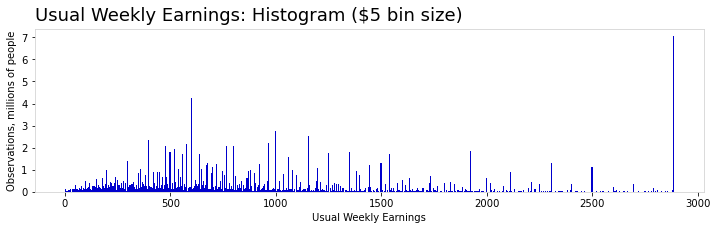

In [11]:
# Histogram
fig, ax = plt.subplots(figsize=(12, 3))
weights = wage_obs['PWORWGT'] / 1_000_000
plt.hist(wage_obs['PRERNWA'], weights=weights, 
         range=(0, 2886), bins=577, color='mediumblue')
ax = plt.gca()
plt.ylabel('Observations, millions of people')
plt.xlabel('Usual Weekly Earnings')
plt.text(0, 1.05, 'Usual Weekly Earnings: Histogram ($5 bin size)',  size=18,
         transform = ax.transAxes);

The first histogram shows a tendency for observations to be located at specific earnings values like \\$600 per week. This topic is discussed in more detail later. With the small wage bin of $5 is not easy to tell the relative probability of earning income in a certain range.

A second histogram plots the relative probability of a wage being within a larger \\$50 range. Each bar represents a \\$50 bin and the height is the share of observations in the bin.

The second histogram shows that values are right-skewed and often still clustered around rounded figures (for example \\$600 per week). Additionally, there are many observations located at the maximum value. This is because the data are topcoded at \\$150,000 per year (\\$2,884.61 per week). 

The next section will look at issues with the data, such as topcoding, and ways around this issue. A later section discusses some options for handling the clustering around rounded values.

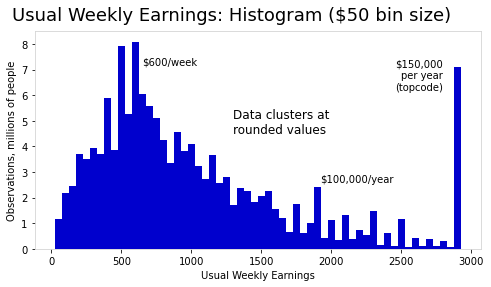

In [12]:
# Histogram
fig, ax = plt.subplots(figsize=(8, 4))
weights = wage_obs['PWORWGT'] / 1_000_000
plt.hist(wage_obs['PRERNWA'], weights=weights, 
         bins=range(25, 2975, 50), color='mediumblue')
plt.ylabel('Observations, millions of people')
plt.xlabel('Usual Weekly Earnings')
plt.text(1923.07, 2.6, '$100,000/year')
plt.text(650, 7.2, '$600/week')
plt.text(2800, 6.2, '$150,000\nper year\n(topcode)', ha='right')
plt.text(1300, 4.5, 'Data clusters at\nrounded values', size=12)
title = 'Usual Weekly Earnings: Histogram ($50 bin size)'
plt.text(-0.05, 1.05, title, size=18, transform=ax.transAxes);

### Limitations of the Data

Even for observations with available data, microdata users need to be aware of specific limitation of the data. For usual weekly earnings data, there are four potential concerns:

1. Topcoded values
2. BLS allocated values (imputed values)
3. Proxy responses
4. Outliers (a bigger issue with wage rate data)

The previous histogram can be divided based on whether the observations reflect any of the first three issues. In the next series of graphs, the lighter area shows observations affected by an issue and the darker area shows the observations that are not affected.

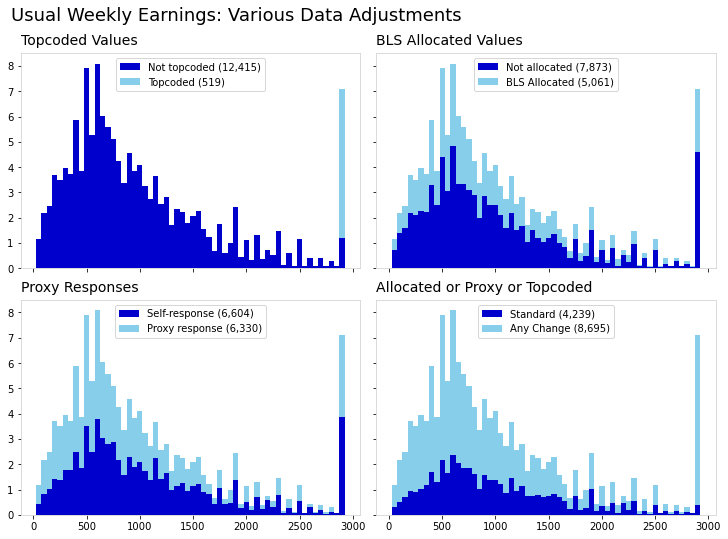

In [13]:
# Potential limitations to the data

## Some new variables of interest
proxy = lambda x: np.where(x.PUSLFPRX.isin([1, 3]), 0, 1)
nonstd = lambda x: np.where((x.PROXY == 1) | 
                            (x.PRWERNAL == 1) | 
                            (x.PTWK == 1), 1, 0)
wage_obs = wage_obs.assign(PROXY = proxy, NONSTD = nonstd)

# Group categories of interest
groups = [((1, 1), 'NONSTD', 'Allocated or Proxy or Topcoded', ['Standard', 'Any Change']),
          ((0, 0), 'PTWK', 'Topcoded Values', ['Not topcoded', 'Topcoded']),
          ((0, 1), 'PRWERNAL', 'BLS Allocated Values', ['Not allocated', 'BLS Allocated']),
          ((1, 0), 'PROXY', 'Proxy Responses', ['Self-response', 'Proxy response']),]

colors = ['mediumblue', 'skyblue']

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, 
                        figsize=(10, 7), constrained_layout=True)

for (x, y), grpvar, title, legend in groups:
    ax = axs[x, y]
    grps = [grp['PRERNWA'] for i, grp in wage_obs.groupby(grpvar)]
    gwgts = [grp['PWORWGT'] / 1000000 for i, grp in wage_obs.groupby(grpvar)]
    leg = [f'{legend[i]} ({len(grp):,.0f})' for i, grp in enumerate(grps)]
    ax.hist(grps, weights=gwgts, stacked=True, bins=range(25, 2975, 50), color=colors)
    ax.text(0, 1.04, title,  size=14, transform = ax.transAxes)
    ax.legend(leg, loc=9)
    
fig.text(0.01, 1.02, 'Usual Weekly Earnings: Various Data Adjustments', size=18);

As a result of these limitation, researchers may want to exclude some observations from their analysis. 

For example, allocated (or imputed) values from BLS come from actual values of other observations with matching characteristics. The match criteria are gender, age, race, education, occupation, hours worked, and receipt of overtime, tips, or commissions (Census 2019).

Research concerning characteristics not included in the match criteria, such as union membership, should exclude imputed wages, because BLS [does not match](http://christopherbollinger.com/wp-content/uploads/2016/08/Match-Bias.pdf) missing and donor wage observations based on union membership. Some imputed wages for union member observations are actually a non-union wage, and some non-union-member observations have an imputed wage from a union member. For a discussion of this, see Hirsch and Schumacher (2004). 

#### Handling adjustments to the data

It's unfortunate that nearly 140,000 person records only include 4,200 unaltered self-reported observations for the usual weekly earnings of wage and salary workers. But it's good that BLS and other researchers have filled in gaps and protect the identity of respondents. 

How a researcher uses the adjusted data will depend on the task at hand. Research that tries to find a causal relationship may want to use only the observations without BLS-imputed values. Research on overall trends may want to add even more imputations. There isn't one blanket response to the wage adjustments; but data users need to know they exist, before using the data.

The next sections calculate descriptive statistics and show some areas where researchers may need to adjust the data or adjust the measurement technique in response to the issues mentioned above.

## Descriptive statistics: Percentile

Researchers instead often calculate the usual wage at various points along the cumulative distribution. This tells us how many people earn below a certain wage. The BLS [published](https://www.bls.gov/news.release/wkyeng.toc.htm) wage statistics from the CPS use this approach. For example, the midpoint of the cumulative wage distribution is the median wage. 

### Weighted and unweighted median

The 50th percentile or median wage is sometimes referred to as the typical wage. Half of earnings are below this point and half are above. 

In [14]:
print(f'Median wage: ${wage_obs.PRERNWA.median():.0f}')

Median wage: $800


The CPS is a non-random sample, so researchers should utilize the sample weights, where possible. For wage data, the appropriate weight is the person outgoing rotation weight, `PWORWGT`. 

In [15]:
# Generate cdf and interpolate over plist values
def cdf_generator(data, wage_var, wgt_var='PWORWGT'):
    '''
    Create cdf from data and wage_var
    '''
    return (data.groupby(wage_var)[wgt_var].sum().cumsum() / 
            data[wgt_var].sum())


def pct_interp(cdf, plist):
    '''
    Return list of x values for percentiles in plist
    '''
    X, PhiX = cdf.index.values, cdf.values
    p = [np.interp(pct, PhiX, X) for pct in plist]
    return p

ecdf = cdf_generator(wage_obs, 'PRERNWA')
median = pct_interp(ecdf, [0.5])[0]

print(f'Weighted median wage: ${median:.0f}')

Weighted median wage: $800


Researchers also look at the wage at various percentiles of the wage distribution. For example, the 10th percentile wage, or first decile wage, is the wage at which 10 percent of wages are lower (and 90 percent are higher). 

The cumulative distribution below shows the value associated with each of several well-known percentiles. The median, or 50th percentile, is the most commonly used and is often considered the "typical" value. The graph also shows the first decile, or 10th percentile, the first quantile (25th percentile), third quantile (75th percentile), and ninth decile (90th percentile). The topcode shows up as a jump in cumulative distribution at the maximum value. 

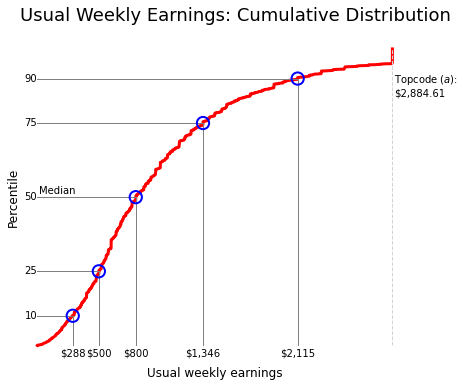

In [16]:
# Graph wage distribution
fig, ax = plt.subplots(figsize=(7, 6))

plist = [0.1, 0.25, 0.5, 0.75, 0.9]
wlist = pct_interp(ecdf, plist)

ecdf.plot(color='red', lw=3)
ax.scatter(wlist, plist, edgecolor='blue', s=150, lw=2,
           facecolors='none', alpha=1, zorder=3)

for w, p in zip(wlist, plist):
    plt.plot([w, w, p], [0, p, p], color='gray', lw=1)
    ax.text(0, p-0.01, f'{p*100:.0f}', ha='right')
    ax.text(w, -0.01, f'${w:,.0f}', ha='center', va='top')

ax.text(10, 0.51, 'Median')
title = 'Usual Weekly Earnings: Cumulative Distribution'
ax.text(0, 1.04, title, size=18, transform = ax.transAxes)

ax.plot([2884.61, 2884.61],[0, 1], ls='--', lw=1, c='lightgray')
ax.text(2900, 0.84, 'Topcode ($a$):\n$2,884.61')
ax.text(-0.015, 0.5, 'Percentile', rotation=90, va='center', 
        ha='center', size=12, transform = ax.transAxes)
ax.text(0.5, -0.04,  'Usual weekly earnings', va='center', 
        ha='center', size=12, transform = ax.transAxes)
ax.axis('off');

The cumulative distribution function using empirical data is pretty smooth in a zoomed out picture. Each blue circle marks the intersection between a specific percentile and the cumulative distribution function, and returns the wage that corresponds to that percentile, and vice versa. 

### Clustering of data and binned percentile

As discussed above, CPS wage data show a tendency to cluster around rounded values. For example, here are is the frequency of earnings observations between \\$1,000 and \\$1,400 per week. The five most common are rounded values, such as \\$1,000 or \\$1,250, or values derived from rounded values, such as \\$1153.84, which is \\$60,000 per year, and \\$1346.15, which is \\$70,000 per year. 

In [17]:
# Five most common values between 1000-1400
(wage_obs.query('1000 <= PRERNWA <= 1400')
         .PRERNWA.value_counts().head())

1000.00    238
1250.00    167
1153.84    140
1346.15    108
1200.00    100
Name: PRERNWA, dtype: int64

While the cumulative distribution function based on empirical data is fairly smooth in a zoomed-out view and compared to the probability density function, the zoomed-in view is less smooth. The clumping around rounded values shows up in the cumulative distribution function, just as it did in the first histogram. For example, 1.4 percent of all responses are exactly \\$800. This means the 49th percentile wage is also the 50th percentile wage. An even larger share of responses, 2.9 percent, are exactly \\$600.

In [18]:
# Share of observations at specific wage
def share_at_wage(group, wage_var, wage):
    '''
    Return share of observations with exact wage
    '''
    sh = group.loc[group[wage_var] == wage, 'NORM_WGT'].sum() 
    return sh * 100

for wage_val in [800, 600]:
    sh = share_at_wage(wage_obs, 'PRERNWA', wage_val)
    print(f'Share reporting exactly ${wage_val} per week: {sh:.2f}%')

Share reporting exactly $800 per week: 1.40%
Share reporting exactly $600 per week: 2.87%


This clustering can cause a measure like the median to return a certain value over many months even as the underlying distribution changes. The solution from BLS, also used by EPI, is shown in the second zoomed in chart. The gray shaded step-shaped-area in the background is the bar that represents each wage bin or interval. The purple line connects these bars and represents the smoothed cumulative distribution function. The intersection of the median and purple line is the green dot, which is above the estimate from the standard technique, at \\$804 per week. A separate orange line connects the bins before and after the bin containing the median. This line evaluated at the median returns \\$808. The orange line represents the technique described by BLS and EPI, as I understand it.

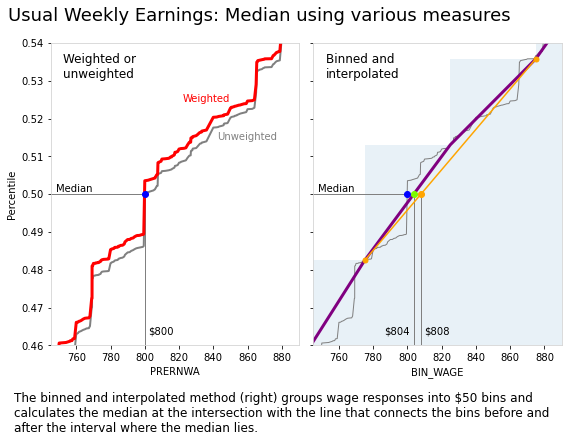

In [19]:
# Graph wage distribution in detail
fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharex=True, 
                        sharey=True, tight_layout=True)
ymin, ymax = 0.46, 0.54
xmin, xmax = 745, 890
axs[0].set_ylim(ymin, ymax)
axs[0].set_xlim(xmin, xmax)

cdfu = cdf_generator(wage_obs, 'PRERNWA', wgt_var='NORM_SUM')
cdfi = cdf_generator(wage_obs, 'BIN_WAGE')
mediani = pct_interp(cdfi, [0.5])[0]

for ax in axs:
    ax.text(748, 0.5, 'Median', va='bottom')
    color = 'red' if ax == axs[0] else 'gray'
    lw = 3 if ax == axs[0] else 1
    (ecdf.loc[(ecdf > 0.45) & (ecdf < 0.55)]
         .plot(ax=ax, color=color, lw=lw, zorder=2))
    ax.scatter(median, [0.5], color='blue', zorder=3)
axs[0].plot([median, median, 0], [0, 0.5, 0.5], 
            color='gray', lw=1, zorder=1)
(cdfu.loc[(cdfu > 0.45) & (cdfu < 0.55)]
     .plot(ax=axs[0], color='gray', lw=2, zorder=1))

axs[0].text(xmin*1.01, ymax*0.995, 'Weighted or \nunweighted', 
            fontsize=12, va='top', ha='left')

axs[0].text(850, 0.524, 'Weighted', color='red', 
            va='bottom', ha='right')
axs[0].text(842, 0.514, 'Unweighted', color='gray', 
            va='bottom', ha='left')
axs[0].set_ylabel('Percentile')
axs[0].text(median + 2, 0.463, f'${median:.0f}', ha='left')

# Ax2
(cdfi.loc[(cdfi > 0.40) & (cdfi < 0.6)]
     .plot(ax=axs[1], color='purple', lw=3, zorder=2))
axs[1].scatter(mediani, [0.5], color='lawngreen', zorder=3)
axs[1].plot([mediani, mediani, 0], [0, 0.5, 0.5], 
            color='gray', lw=1, zorder=1)
for xval in [700, 750, 800, 850, 900]:
    rect = Rectangle((xval-25, 0), 50, cdfi.loc[xval+25], 
                     zorder=0, alpha=0.1)
    axs[1].add_patch(rect)
    
# BLS method
axs[1].text(xmin*1.01, ymax*0.995, 'Binned and\ninterpolated', 
            fontsize=12, va='top', ha='left')
X = [775, 875]
Y = [cdfi.loc[775], cdfi.loc[875]]
axs[1].plot(X, Y, c='orange', zorder=2, marker='.', ms=10)
medianb = np.interp(0.5, [cdfi.loc[775], cdfi.loc[875]], [775, 875])
axs[1].plot([medianb, medianb, 0], [0, 0.5, 0.5], 
            color='gray', lw=1, zorder=1)
axs[1].scatter(medianb, 0.5, color='orange', zorder=3)    
axs[1].text(mediani - 2, 0.463, f'${mediani:.0f}', ha='right')
axs[1].text(medianb + 2, 0.463, f'${medianb:.0f}', ha='left')
    
title = 'Usual Weekly Earnings: Median using various measures'
fig.text(0.02, 1.02, title, size=18)    

footer = ('The binned and interpolated method (right) groups '
          'wage responses into $50 bins and\ncalculates the '+
          'median at the intersection with the line that '+
          'connects the bins before and\nafter the interval '+
          'where the median lies.')
fig.text(0.03, -0.01, footer, size=12, va='top')    
    
plt.show()

In published statistics from BLS, the median and other percentiles are calculated using a method that reduces the effect of clustering around rounded values. From the Usual Weekly Earnings [technical note](https://www.bls.gov/news.release/wkyeng.tn.htm):

```
The BLS procedure for estimating the median of an earnings distribution places each 
reported or calculated weekly earnings value into a $50-wide interval that is centered
around a multiple of $50. The median is calculated through the linear interpolation of 
the interval in which the median lies.

```

Likewise, the Economic Policy Institute (EPI) also [use](https://www.epi.org/data/methodology/) binning and interpolation to smooth the cumulative distribution function. From EPI:

```
We then find the bins on either side of each decile and perform a weighted, linear interpolation to locate the wage cutoffs for each of the particular deciles. The weights for the interpolation are derived from differences in the cumulative percentages on either side of the decile.
```
#### Binned percentile example
Let's work through an example of the binned and interpolated wage calculation for median usual weekly earnings in October 2019. 

Previously, we have grouped the data into bins that correspond to \\$50 intervals and are centered on multiples of \\$50. These groups were used to smooth the data in the histogram and the same approach applies here.

Specifically, we group the data in groups with interval width $g$, starting at $n$ and going to $N$. 

$[n - \frac{g}{2}, n + \frac{g}{2})$ for $n$ in $[n, n+g, ..., N]$.

We can create these groups using a function, $G(x)$ that returns the endpoint of the group containing wage value $x$, as:

$G(x) = g\lfloor \frac{x}{g} + \frac{1}{2} \rfloor + \frac{g}{2}$,

where $\lfloor x + \frac{1}{2} \rfloor$ is $x$ rounded to the nearest integer. Note these are not square brackets but the notation representing the floor function. The $\frac{g}{2}$ term at the end adjusts so that the endpoint of the interval $[n - \frac{g}{2}, n + \frac{g}{2})$ is returned. 

So, for example, when $g = 50$, then $G(800) = 50\lfloor \frac{800}{50} + \frac{1}{2} \rfloor + \frac{50}{2} = 825$. The function returns the endpoint of the interval containing 800.

In [20]:
# Function to create bin from x and bin size
def G(x, g):
    '''
    Return the group or bin for x when groupsize is g
    '''
    G = g*round(x/g + 0.5)+(0.5*g)
    return G

print(f'G(800) = {G(800, 50)}')

G(800) = 825.0


We use these groups to smooth out the cumulative distribution function. We use two specific bins to calculate the interpolated binned median. Since the bin for the value of the empirical median (\\$800) runs from $[775, 825)$, we use the bin from $[725, 775)$ and the bin from $[825, 875)$; these are the bins before and after the bin containing the median. The cumulative distribution for these bins (the share of observations with earnings in the bin or below it) is 0.483 and 0.534, respectively. 

The point that represents the lower bin is (775, 0.483) and the point for the higher bin is (875, 0.534). Since we use the endpoints of the bins to know how many people have earnings in the bin or below, we can draw a line from the bin before the median to the bin after the median (the orange line above).

The line, represented by these two endpoints $(x_1, y_1), (x_2, y_2)$, intersects with the median at wage value $x$ that is of interest to us--it is our estimate of the binned and interpolated median wage. We can use numpy to solve for this value, or use any of several mathematical techniques. For this example, I'll calculate the function represented by the line connecting our two bins of interest, then evaluate the function at the median ($y=0.5$).

Let $y = mx + b$, where $y$ is the probability of earning a certain wage or less, $m$ is the slope of the line that plots the function, $x$ is the wage, and $b$ is the intercept or y value associated with a wage of 0 in the function. 

The slope, $m$, is the rate at which an increase in wages causes ones earnings to become greater than other peoples' earnings. We can solve for the slope using the rate of change in y divided by the rate of change in x, or

$m = \frac{y_2 - y_1}{x_2 - x_1} = \frac{0.534 - 0.483}{875 - 775} = \frac{0.51}{100} = 0.00051$

Knowing $m$, we can solve for $b$ by plugging in the $x$ and $y$ from either of the two points. 

$b = 0.483 - (0.00051*(775)) = 0.088$

Once we have $b$, we can evaluate where $y = 0.5$ for $x$, which rearranges to $x = \frac{0.5 - b}{m}$. The estimated median using data binning and interpolation is given by:

$x = \frac{0.5 - 0.088}{0.00051} = 808.33$

This is very close to the value calculated above, with minor differences from rounding. 

In [21]:
# Python function returns percentile using interpolation
def pct_interp_bin(cdf, perc):
    '''
    Linear interpolation through the bin
    before and after the bin containing percentile perc.
    CDF should be based on binned wages.
    '''
    x1, y1 = cdf[cdf < 0.5].index[-1], cdf[cdf < 0.5].iloc[-1]
    x2, y2 = cdf[cdf > 0.5].index[1], cdf[cdf > 0.5].iloc[1]

    return np.interp(perc, [y1, y2], [x1, x2])

med = f'${pct_interp_bin(cdfi, 0.5):.2f}'
print(f'Median from interpolation of bins before and after: {med}')

Median from interpolation of bins before and after: $807.82


#### Comparing results

Comparing different calculations of the median earnings in October 2019 won't demonstrate the reason for smoothing the wage data. The issue is that wage percentile measures get stuck on rounded values. The best demonstration comes at the end of the notebook in the section that covers longer period of time, but for now let's add in two more months of CPS data for comparison. 

Adding the November 2019 and December 2019 data allows us to see if wages get stuck at rounded values over multiple months. If this happens, the percentile wage growth is zero over the period, even though the share of people earning the rounded value changes. 

In [22]:
# Create new dataset with three months of observations

# Usually work FT (35+ hours) for comparing to BLS stats
uslft = lambda x: np.where((x.PEHRUSL1 >= 35) | (x.PEHRFTPT == 1), 1, 0)

data = pd.DataFrame()
for file in ['oct19pub.dat', 'nov19pub.dat', 'dec19pub.dat']:
    dfm = (cps_unpack_month(file, cps_unpacker(m), cols)
           .pipe(cps_decimal_adjust, [earnvars, wgtvars]))
    wm = dfm.loc[dfm.PRERNWA > 0].copy()
    wm = wm.assign(BIN_WAGE = bin_wage, USLFT = uslft)
    data = data.append(wm)

In [23]:
# Table showing results over time
print('Table 3.\nMedian usual weekly earnings, usually full-time')
res = pd.DataFrame(dtype='float')
groups = [('Q4 `19', [10, 11, 12]), ('Oct `19', [10]), 
          ('Nov `19', [11]), ('Dec `19', [12])]
for mon, month in groups:
    datam = data.query('HRMONTH in @month and USLFT == 1')
    res.loc['Simple median', mon] = datam.PRERNWA.median()
    cdfm = cdf_generator(datam, 'PRERNWA')
    res.loc['Weighted median', mon] = pct_interp(cdfm, [0.5])[0]
    cdfmi = cdf_generator(datam, 'BIN_WAGE')
    name = 'Binned and interpolated median'
    res.loc[name, mon] = pct_interp_bin(cdfmi, 0.5)

BLSval = fred['LEU0252881500Q'].loc['2019-10-01', 'VALUE']    
res.loc['BLS reported data (quarterly)', groups[0][0]] = BLSval
res.style.format('${:,.2f}', na_rep='-')

Table 3.
Median usual weekly earnings, usually full-time


,Q4 `19,Oct `19,Nov `19,Dec `19
Simple median,$960.26,$960.00,$961.00,$960.00
Weighted median,$949.90,$942.28,$960.17,$936.58
Binned and interpolated median,$935.35,$932.40,$946.06,$927.87
BLS reported data (quarterly),$936.00,-,-,-


While the clustering around rounded values is an issue, the solution is fairly straightforward and non-controversial. Statistical agencies err on the side of caution, so the BLS seal of approval for using the interpolated binned wage should be comforting.

The next section covers a more challenging issue. The censoring of wage data above \\$150,000 per year complicates calculations of mean and variance.

## Descriptive statistics: mean

Estimates of average weekly earnings are complicated by topcoding in CPS data. CPS wage data are right-censored. The values in the right tail of the distribution, wages above \\$150,000 per year, are replaced with the topcode, equivalent to \\$150,000 per year. This means the average calculated from the censored data is below the true average.

This section doesn't solve that problem. It calculates estimates of the mean by replacing the censored data with estimates of the average censored value. This is essentially a work-around for the specific problem of calculating a mean wage, but it won't work for solving other problems created by censored data. 

### Estimating the mean above the topcode

Using assumptions about the distribution of usual weekly earnings, we can estimate the mean of the censored portion of the data, referred to as the mean above the topcode. Three techniques for doing so are discussed in this section. Depending on the use case, none of these approaches may be suitable, as they all apply a new censored value in place of the old censored value. 

#### Lognormal distribution

First, let's examine the technique from John Schmitt (2003), used in the Center for Economic and Policy Research (CEPR) CPS ORG partial extracts, which assumes that usual weekly earnings are lognormally distributed (the natural log of usual weekly earnings is normally distributed). To start, let $x$ = usual weekly earnings and $y^* = ln(x)$. Values in the censored data, $y$, are topcoded at $a$, such that $y = a$ if $y^* > a$ else $y = y^*$.

We know the mean of the censored data (E[$y$]). We also know the topcode ($a$), and what share of the data are not topcoded ($\Phi$). Information on the topcoded share of observations is derived from CPS variable `PTWK`. In October 2019, about 95.9% of earnings observations are uncensored, meaning around 4.1% of observations are topcoded ($1 - \Phi$).  

Knowing $\Phi$ tells us how many standard deviations the topcode is from the true mean. This is because the percent point function of $\Phi$ returns ($\alpha$), the distance from the mean, in standard deviations, for a standard normal distribution. The topcode's distance from mean also allows us to identify the probability density associated with the topcode (how relatively likely a value is to be near the topcode). 

In [24]:
# Parameters of the censored data
print('Values below show natural log')
ys = np.log(wage_obs['PRERNWA'])
weights = wage_obs['PWORWGT']
mu_s = np.average(ys, weights=weights)
print(f'Censored data mean: {mu_s:.3f}')
sigma_s = np.sqrt(np.cov(ys, aweights=weights))
print(f'Censored data standard deviation: {sigma_s:.3f}')
a = np.log(2884.61) # topcode = 150,000 / 52
print(f'Topcode: {a:.3f}')
top_coded_share = (wage_obs.loc[wage_obs.PTWK == 1, 'PWORWGT'].sum() / 
                   wage_obs.PWORWGT.sum())
print(f'Topcoded share of data: {top_coded_share:.3f}')
Phi = 1 - top_coded_share
print(f'Uncensored share of data: {Phi:.3f}')
alpha = norm.ppf(Phi)
print(f'Topcode standard deviations from the mean: {alpha:.3f}')
pdf_a = norm.pdf(alpha)
print(f'Probability density of topcode: {pdf_a:.3f}')

Values below show natural log
Censored data mean: 6.648
Censored data standard deviation: 0.829
Topcode: 7.967
Topcoded share of data: 0.041
Uncensored share of data: 0.959
Topcode standard deviations from the mean: 1.734
Probability density of topcode: 0.089


To solve for the true mean, $\mu$, and the standard deviation, $\sigma$, we utilize certain properties of a censored normal variable. 

When the upper portion of the distribution is censored, the expected value of the censored distribution can be expressed as

E$[y] = (1 - \Phi)a + \Phi(\mu - \sigma \lambda)$, where

$\Phi(\frac{a - \mu}{\sigma}) = \Phi(\alpha) = P(y^* < a) = \Phi$, and 

$\lambda = \frac{\phi(\alpha)}{\Phi(\alpha)}$,

where $\phi(\alpha)$ is the standard normal probability density function and $\Phi(\alpha)$ is the standard normal cumulative distribution function. 

The ratio represented by $\lambda$ is the inverse Mill's ratio, and tells us the expected value of the censored area. In a standard normal probability density function, the inverse Mill's ratio is the height at the cutoff divided by the area under the curve and above the cutoff. 

The function for the expected value of a censored normal variable decomposes the censored data mean into the portion from the censored values and the uncensored portion, which is the true mean, and an adjustment for the expected value of the censored portion. In the case of topcoded CPS earnings, the mean of the censored data is below the true mean, so $\lambda$ is negative. In other words, the expected value of the censored portion of wages is captured by the true mean, but not by the censored data mean. 

Rearranging and substituting:

$\sigma = \frac{a - E[y]}{\Phi (\alpha - \lambda)}$, and

$\mu = a - (\alpha \sigma)$

Finally, the mean above the topcode is estimated as a truncated standard normal distribution, where

E$[y^*|y>a] = \mu + \sigma\frac{\phi(\alpha)}{1-\Phi(\alpha)}$.

In [25]:
# Replicate math above with python function
def mtc_cepr(data, weights, topcode, topcode_share):
    '''
    Estimate mean above topcode for lognormally distributed data
    '''
    a = np.log(topcode)
    phi = 1 - topcode_share
    y = np.log(data)
    X = np.average(y, weights=weights)
    alpha = norm.ppf(phi) 
    lmbda = -norm.pdf(alpha) / phi
    sigma = (a - X) / (phi * (alpha - lmbda))
    mu = a - (alpha * sigma)
    hlambda = norm.pdf(alpha) / (1 - norm.cdf(alpha))
    mtc = mu + sigma * hlambda
    
    return np.exp(mtc)

In [26]:
# Calculate mean above topcode and estimate true mean
wages = wage_obs.PRERNWA.values
wgts = wage_obs.PWORWGT.values

# Topcoded share of wage group
tc_share = (wage_obs.loc[wage_obs.PTWK == 1, 'PWORWGT'].sum() / 
            wage_obs.PWORWGT.sum())

# Mean above topcode
mtc = mtc_cepr(wages, wgts, 2884.61, tc_share)
print(f'Mean above topcode: ${mtc:,.2f}')

# Censored mean
cm = np.average(wages, weights=wgts)
print(f'Censored mean: ${cm:,.2f}')

# Estimated true mean
wage2 = (lambda x: np.where(x.PTWK == 1, 
                            mtc.round(2), 
                            x.PRERNWA))
wages2 = wage_obs.assign(WAGE2 = wage2).WAGE2.values
em = np.average(wages2, weights=wgts)
print(f'Estimated true mean: ${em:,.2f}')

Mean above topcode: $3,915.68
Censored mean: $1,014.44
Estimated true mean: $1,057.16


#### Estimates for men and women, separately

The CPS extracts from CEPR and EPI estimate the mean above the topcode separately for men and women. This breaks the cluster at the maximum value of the wage data into three separate values: those with usual weekly earnings of $150,000 per year (those not topcoded but actually earning the topcode), the new topcode for men, and the new topcode for women. Here's the estimates for men and women in October 2019:

In [27]:
# Calculate separate mean above topcode for men and women
wage_obs['WAGE3'] = wage_obs['PRERNWA'].copy()
for sex, sid in [('Men', 1), ('Women', 2)]:
    wage_grp = wage_obs.query('PESEX == @sid')
    wages = wage_grp.PRERNWA.values
    wgts = wage_grp.PWORWGT.values
    # Topcoded share of wage group
    tc_share = (wage_grp.loc[wage_grp.PTWK == 1, 'PWORWGT'].sum() / 
                wage_grp.PWORWGT.sum())
    # Mean above topcode
    mtc = mtc_cepr(wages, wgts, 2884.61, tc_share)
    print(f'Mean above topcode, {sex}: ${mtc:,.2f}')
    wage_obs.loc[(wage_obs['PESEX'] == sid) & 
                 (wage_obs['PTWK'] == 1), 'WAGE3'] = mtc

Mean above topcode, Men: $3,962.38
Mean above topcode, Women: $3,790.32


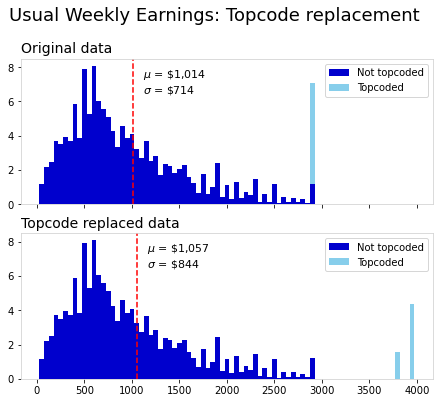

In [28]:
# Topcode adjusted vs unadjusted
groups = [(0, 'PRERNWA', 'Original data'),
          (1, 'WAGE3', 'Topcode replaced data')]

colors = ['mediumblue', 'skyblue']

fig, axs = plt.subplots(2, 1, sharey=True, sharex=True, 
                        figsize=(6, 5), constrained_layout=True)

weights = wage_obs['PWORWGT']
for x, wagevar, title, in groups:
    ax = axs[x]
    mu = np.average(wage_obs[wagevar], weights=weights)
    sigma = np.sqrt(np.cov(wage_obs[wagevar], aweights=weights))
    grps = [grp[wagevar] for i, grp in wage_obs.groupby('PTWK')]
    gwgts = [grp['PWORWGT'] / 1000000 for i, grp in wage_obs.groupby('PTWK')]
    ax.hist(grps, weights=gwgts, stacked=True, bins=range(25, 4025, 50), color=colors)
    ax.text(0, 1.04, title,  size=14, transform=ax.transAxes)
    ax.legend(['Not topcoded', 'Topcoded'], loc=1)
    ax.axvline(mu, ls='--', color='red')
    stats = f'$\mu$ = \${mu:,.0f}\n$\sigma$ = \${sigma:,.0f}'
    ax.text(mu + 100, 6.5, stats, size=11, ha='left')
    
fig.text(0.01, 1.05, 'Usual Weekly Earnings: Topcode replacement', size=18);

Replacing the censored values with the new estimated mean above the topcode increases the mean wage and standard deviation. The mean is shown by the dashed red line on each plot. The new histogram is more-like the actual underlying data, but still suffers from most of the issues of the previous histogram. Primarily, there are now only two vales (representing men and women) above the topcode. The lack of variation above the topcode hinders efforts to explain usual weekly earnings based on personal characteristics other than gender.

Separate estimates for men and women leads into the idea of using more characteristics about individuals to estimate their uncensored wage. Guides for handling missing data, such as *Applied Missing Data Analysis* by Craig Enders, discuss techniques that use a regression to estimate the censored values for individuals and then apply some random noise to make the variance more like the actual data. This is referred to as stochaistic regression imputation, and is used for data that is missing at random (MAR). More sophisticated models are not covered in this notebook. 

For practical purposes, I will take a look quickly at a version of the previous technique that creates eight estimates based on gender and additionally the four Census regions. This is the version I intend to implement in the bd CPS.

In [29]:
# Region and gender groups
print('Mean above the topcode by group:')
wage_obs['WAGE_'] = wage_obs['PRERNWA'].copy()
dreg = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}
for region in [1, 2, 3, 4]:
    print(f'  {dreg[region]} Region')
    for sex, sid in [('Men:    ', 1), ('Women:  ', 2)]:
        wage_grp = wage_obs.query('PESEX == @sid and GEREG == @region')
        wages = wage_grp.PRERNWA.values
        wgts = wage_grp.PWORWGT.values
        # Topcoded share of wage group
        tc_share = (wage_grp.loc[wage_grp.PTWK == 1, 'PWORWGT'].sum() / 
                    wage_grp.PWORWGT.sum())
        # Mean above topcode
        mtc = mtc_cepr(wages, wgts, 2884.61, tc_share)
        print(f'    {sex}     ${mtc:,.2f}')
        wage_obs.loc[(wage_obs['PESEX'] == sid) & 
                     (wage_obs['GEREG'] == region), 'WAGE_'] = mtc

Mean above the topcode by group:
  Northeast Region
    Men:         $4,042.09
    Women:       $3,871.50
  Midwest Region
    Men:         $3,821.16
    Women:       $3,703.61
  South Region
    Men:         $3,893.06
    Women:       $3,714.95
  West Region
    Men:         $4,097.52
    Women:       $3,886.58


### Another approach assuming lognormal distribution

There are multiple ways to estimate the mean above the topcode. Another option is to fit a lognormal distribution to the data and use the fitted distribution to calculate the mean above the topcode and estimate the true mean. Maximum likelihood estimation (MLE) provides the log-normal distribution shape and scale parameters that make the observed values the most likely sample among all possible samples. We then calculated the expected value for the area above the topcode and the expected value of the full uncensored distribution, using the fitted curve.

Mean above the topcode: $4,347.50
Estimated true mean: $1,085.72


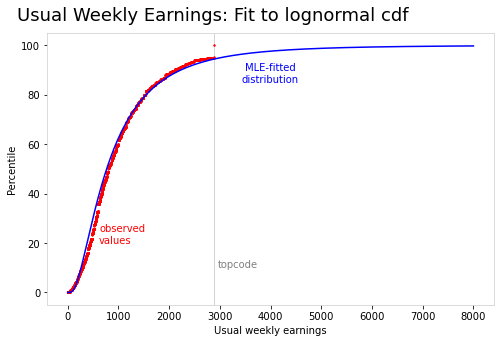

In [30]:
# Fitting distribution to data
def mtc_mle(data, topcode):
    '''
    MLE fitting log-normal distribution to sample
    '''
    s, loc, scale = lognorm.fit(data.PRERNWA, floc=0)
    mean = lognorm.stats(s, scale=scale, moments='m')

    mtc = lognorm.expect(lambda x: x, args=(s,), scale=scale, 
                         lb=topcode, conditional=True)
    return mtc, mean, s, scale

mtc, mean, s, scale = mtc_mle(wage_obs, 2884.61)
print(f'Mean above the topcode: ${mtc:,.2f}')
print(f'Estimated true mean: ${mean:,.2f}')

# Graph of fitted and observed values
fig, ax = plt.subplots(figsize=(8, 5))
x = np.linspace(0, 8000, 10000)
cdf = lognorm.cdf(x, s=s, scale=scale)
plt.plot(x, cdf * 100, color='blue')

# Plot data from ecdf above
plt.scatter(ecdf.index.values, ecdf.values * 100, 
            color='red', s=2)
plt.axvline(2884.61, color='lightgray', 
            lw=1, zorder=0)
plt.text(2960, 10, 'topcode', color='gray')
plt.text(620, 20, 'observed\nvalues', color='red')
plt.text(4000, 85, 'MLE-fitted\ndistribution', 
         color='blue', ha='center')
plt.text(-1000, 110, 'Usual Weekly Earnings: Fit to lognormal cdf', 
        size=18)
plt.xlabel('Usual weekly earnings')
plt.ylabel('Percentile');

A lognormal distribution fits the uncensored wage data very well. Importantly, however, economists argue that the censored portion of the wage data have different characteristics from the uncensored data. Specifically, the top two or three percent of the wage distribution follows a Pareto distribution.

### Pareto distribution

The Pareto distribution gives the probability of usual weekly earnings, $y$, is greater than $x$ as:

$Pr(y>x) = (\frac{k}{x})^{\alpha}$,

where $k$ is the minimum value where the Pareto distribution applies and $\alpha$ is the parameter of interest and determines the shape of the distribution. As $x$ gets further away from the minimum value, it becomes less likely. the key step is estimating $\alpha$, which determines the shape of this dropoff in density as $x$ moves further from the minimum value.

The CPS extracts from the Economic Policy Institute (EPI) assume that topcoded wages follow a Pareto distribution, and use this assumption to estimate the mean above the topcode. The EPI extracts use the 80th percentile wage as $k$ and estimate $\alpha$ based on the wage distribution for the top 20 percent of wage earners.

Perhaps the best way to see this is with a log-log graph showing population below a certain wage value and the wage value. This type of graph takes the natural log of both variables, which allows us to see areas where the Pareto distribution fits the data as areas where the data are in a straight line. The slope of this line provides our estimate of $\alpha$. 

The math behind this comes from taking the log of the probability density function above: 

$ln \phi(x) = ln(\alpha\frac{k^{\alpha}}{x^{\alpha + 1}}) = ln(\alpha k^{\alpha}) - (\alpha + 1)ln(x)$,

which converts the function into a linear model that we can estimate using the data. 

Summed up, we want to know how the likelihood of someone having a certain income, $x$, falls as $x$ increases. We know how many high wage earners exist but don't know how their wages are distributed. If we assume the pattern or distribution in the group of people with income below them is the same as the pattern for their income, we can estimate their income. 

In [31]:
# Function to calculate Pareto-imputed mean
def mtc_pareto(df, threshold, topcode):
    '''
    Return Pareto-imputed mean above topcode
    Also return data for graphing result
    '''
    #Separate 150k from topcode
    split_tc = lambda x: np.where(x.PTWK == 1, 
                                  x.PRERNWA + 50, 
                                  x.PRERNWA)
    df = df.assign(SPLIT_TC = split_tc)
    data = df.SPLIT_TC
    weights = df.PWORWGT
    
    # Value at threshold 
    cdf = cdf_generator(df, 'SPLIT_TC')
    threshold_val = pct_interp(cdf, [threshold])[0]
    
    df['bin_wage'] = (data.divide(50).round()
                          .multiply(50) + 25)

    wg = pd.DataFrame()
    wg['counts'] = (df.groupby('bin_wage')
                      .PWORWGT.sum()
                      .sort_index(ascending=False))
    wg['cs'] = wg.cumsum()
    
    yf = np.log(wg['cs'].values)
    xf = np.log(wg.index.values)
    
    # Above threshold only
    pa = wg[wg.index >= round(threshold_val / 50)*50]
    ln_pop_cs = np.log(pa['cs'].values)
    ln_bin = np.log(pa.index.values)
    
    # OLS y = mx + b 
    y = ln_pop_cs
    x = ln_bin
    cov = np.cov(x, y)
    cc = np.corrcoef(x, y)
    m, b = np.polyfit(x, y, 1)
    fn_text = f'$y = {b:.1f} - {abs(m):.3f}x$'
    
    # Mean above topcode
    alpha = -m
    mtc = topcode * (alpha / (alpha - 1))
    
    # Threshold as round number
    tr = round((1 - threshold) * 100)
    
    d = {'yf': yf, 'xf': xf, 'y': y, 'x': x,
         'm': m, 'b': b, 'fn_text': fn_text,
         'mtc': mtc, 'threshold': threshold,
         'threshold_val': threshold_val,
         'topcode': topcode, 'cov': cov, 
         'cc': cc, 'tr': tr}
    
    return d

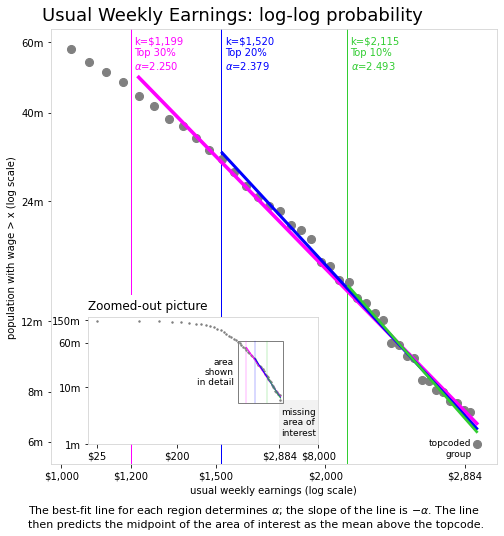

In [32]:
# Graph wage distribution
fig, ax = plt.subplots(figsize=(8,8))
d = mtc_pareto(wage_obs, 0.7, 2884.61)

ax.scatter(d['xf'][:40], d['yf'][:40], color='gray', s=65)
ax.text(-0.02, 1.02, 'Usual Weekly Earnings: log-log probability', 
        size=18, transform = ax.transAxes)

left, bottom, width, height = [0.19, 0.16, 0.40, 0.22]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.scatter(d['xf'], d['yf'], color='gray', s=2)

# Custom tick marks for log-log
axticks = [[1000, 1200, 1500, 2000, 2884], [6, 8, 12, 24, 40, 60]]
ax2ticks = [[25, 200, 2884, 8000], [1, 10, 60, 150]]
for axn, axnticks in [(ax, axticks), (ax2, ax2ticks)]:
    xticks, xticklabels = zip(*[(np.log(i), f'${i:,.0f}') 
                                 for i in axnticks[0]])
    yticks, yticklabels = zip(*[(np.log(i*1_000_000), f'{i}m')  
                                 for i in axnticks[1]])
    axn.set_yticks(yticks)
    axn.set_yticklabels(yticklabels)
    axn.set_xticks(xticks)
    axn.set_xticklabels(xticklabels)

xl, xh = ax.get_xlim()
yl, yh = ax.get_ylim()
sel_w = xh - xl
sel_h = yh - yl
sel_sp = (xl, yl)
rect = Rectangle(sel_sp, sel_w, sel_h, linewidth=1, zorder=0,
                         edgecolor='gray', facecolor='none')

ax2ylim = ax2.get_ylim()
ax2xlim = ax2.get_xlim()
aoi_sp = (np.log(2884), ax2ylim[0])
aoi_w = ax2xlim[1] - np.log(2884.61)
aoi_h = d['yf'][0] - ax2ylim[0]
aoi_c = (aoi_sp[0] + (aoi_w / 2), aoi_sp[1] + (aoi_h / 2))
aoi_rect = Rectangle(aoi_sp, aoi_w, aoi_h, zorder=0, clip_on=True,
                             ec='none', fc='gray', alpha=0.1)

ax.set_ylim(yl, yh)
ax.set_xlim(xl, xh)
ax2.set_ylim(ax2ylim)
ax2.set_xlim(ax2xlim)
ky = ax.get_ylim()
fit_settings = [(0.7, 'magenta', 1.2), 
                (0.8, 'blue', 1.0),  
                (0.9, 'limegreen', 0.9)]
for thresh, color, lwa in fit_settings: 
    d = mtc_pareto(wage_obs, thresh, 2884.61)
    kx = np.log(d['threshold_val'])
    x_vals = np.array((d['x'].min(), d['x'].max()))
    y_vals = d['b'] + d['m'] * x_vals
    text = f'k=${d["threshold_val"]:,.0f}\nTop {d["tr"]}%\n$\\alpha$={-d["m"]:.3f}'
    ax.text(kx+0.01, 17.95, text, 
            c=color, ha='left', va='top')
    for axn in [ax, ax2]:
        lw = 1 if axn == ax else 0.3
        axn.plot([kx, kx], ky, c=color, lw=lw, zorder=0)
        axn.plot(x_vals, y_vals, c=color, lw=lw*3*lwa, zorder=3)

ax.set_ylabel('population with wage > x (log scale)')
ax.set_xlabel('usual weekly earnings (log scale)')        
        
# Add the patch to the Axes
ax2.add_patch(rect)
ax2.add_patch(aoi_rect)
aoi_txt = 'missing\narea of\ninterest'
ax2.text(aoi_c[0], aoi_c[1], aoi_txt, size=9, ha='center', va='center')
sel_text = 'area\nshown\nin detail'
ax2.text(sel_sp[0] - 0.1, sel_sp[1] + (sel_h / 2), sel_text, size=9,
         ha='right', va='center')
ax2.text(0, 1.09, 'Zoomed-out picture', size=12, backgroundcolor='white',
         ha='left', va='center', transform = ax2.transAxes)

ax.text(np.log(2884.61 + 50), yl+0.09, 'topcoded\ngroup', 
        size=9, ha='right', va='center')

note = ('The best-fit line for each region determines $\\alpha$; the '+
        'slope of the line is $-\\alpha$. The line\nthen predicts the '+
        'midpoint of the area of interest as the mean above the topcode.')

ax.text(-0.05, -0.09, note, size=11, ha='left', va='top', transform = ax.transAxes)

plt.show()

The top 20--30 percent of wages seems to fit a Pareto distribution reasonably well, from the log-log plot above. The bottom 70 percent or so of wages do not (see zoomed out picture in inset graph). 

The graph shows the line that best approximates the distribution for each of three subgroups: 1) $k$, the minimum value of the area assumed to be Pareto distributed, is set to cover the top 30 percent of wages, those earning \\$1,200 per week or more; 2) the top 20 percent, earning \\$1,520 or more per week; and 3) the top 10 percent, earning \\$2,115 or more per week. The EPI model uses the second threshold, the top 20 percent, which seems to fit the data better than the larger group while using more data than the smaller group. 

The topcoded group is separated in the graph from the non-topcoded observations who report earning \\$150,000 per year. The x value for this group is incorrect, so the results from this procedure are affected by how the topcoded group itself is handled, in addition to the choice of cutoff. 

#### Pareto-imputed mean above topcode

Using the estimate of $\alpha$ derived above, we can estimate the mean above the topcode as

$E[x] = \frac{\alpha}{\alpha-1}a$

Where $a$ is the topcode. In the graph above, this could be thought of as finding the midpoint of the missing area of interest, which ranges from the topcode to the maximum income and covers the roughly four percent of observerations that are topcoded.

In [33]:
# Pareto imputed mean above the topcode
for thresh in [0.7, 0.8, 0.9]:
    d = mtc_pareto(wage_obs, thresh, 2884.61)
    mtc = d['mtc']
    print(f'Mean above topcode, based on top {d["tr"]} percent: ${mtc:,.2f}')

Mean above topcode, based on top 30 percent: $5,193.09
Mean above topcode, based on top 20 percent: $4,976.81
Mean above topcode, based on top 10 percent: $4,816.98


Note, when comparing results to CEPR and EPI extracts, the methodology used above is the same, but I separate the topcoded group from those earning \\$150,000. This is done using a second variable, `PTWK`, because the data show both groups as \\$2,884.61 in `PRERNWA`. In periods prior to 1998, this was less of an issue, as the topcode value was much less common, such as \\$1,999. But many people report actually earning the topcode value, and there is no need to replace the wages for these people, as they are not topcoded.

#### Comparing estimates of the mean above the topcode

The results from these methods match the results found by Schmitt (2003). The estimated mean above the topcode is lower when assuming wages are log-normally distributed and higher when assuming top wages are Pareto distributed. Both methods provide plausible results and improve estimates of mean and standard deviation from CPS earnings data. 

The results for October 2019 are summarized in this section. Results are also discussed in the bigger context of changes over time in a later section.

##### October 2019 Results Summary

The estimated mean above the topcode is shown in table 4 for the total group of wage observations, as well as separate values for men and women. The table also shows the same calculations for non-hourly workers. Table 5 shows the estimate based on those with no BLS earnings allocations and for the fourth and eighth interview subgroups, separately. 

In table 6, the estimated uncensored data mean is shown for the three methods above, 1) log-normal distribution using parameters, 2) log-normal distribution using maximum likelihood estimation, and 3) pareto distribution with minimums set at the 70th, 80th, and 90th percentiles. 

Additionally, an estimate based on national accounts is included for comparison to aggregate data. The aggregate data estimate comes from wages and salaries, from the personal income and outlays report for October 2019, divided by the estimated number of wage and salary workers for the same period, from the CPS. 

In [34]:
# Table 4. Mean above the topcode: Total, Men, Women
print('Table 4. Mean above the topcode: Total, Men, Women')
total = wage_obs
men = wage_obs.query('PESEX == 1')
women = wage_obs.query('PESEX == 2')

groups = [('Total', total), ('Men', men), ('Women', women)]
hrly = [('Full sample', [1, 2]), ('Non-hourly only', [2])]
gnames = [i[0] for i in groups]
hnames = [i[0] for i in hrly]
coln = pd.MultiIndex.from_product([hnames, gnames])
t4 = pd.DataFrame(columns=coln)
for (name, group), (hn, h) in product(groups, hrly):
    group = group.query('PEERNHRY in @h')
    # CEPR Log-normal
    wages = group.PRERNWA.values
    wgts = group.PWORWGT.values
    gteqtc = group.PRERNWA >= 2884.61
    # Variation using PTWK
    tc_share2 = (group.loc[(group.PTWK == 1), 'PWORWGT'].sum() / 
                 group.PWORWGT.sum())
    mtc = mtc_cepr(wages, wgts, 2884.61, tc_share2)
    cname = 'Log-normal, based on PTWK'
    t4.loc[cname, (hn, name)] = mtc
    # Original Schmitt/CEPR approach
    tc_share = (group.loc[gteqtc, 'PWORWGT'].sum() / 
                group.PWORWGT.sum())
    mtc = mtc_cepr(wages, wgts, 2884.61, tc_share)
    cname = 'Log-normal, Schmitt/CEPR'
    t4.loc[cname, (hn, name)] = mtc
    # MLE Log-normal
    mtc, mean, s, scale = mtc_mle(group, 2884.61)
    cname = 'Log-normal, fit with MLE'
    t4.loc[cname, (hn, name)] = mtc
    # Pareto/EPI
    for thresh in [0.9, 0.8, 0.7]:
        if thresh < (1 - tc_share - 0.02):
            mtcpd = mtc_pareto(group, thresh, 2884.61)
            mtc = mtcpd['mtc']
        else:
            mtc = 0
        ptitle = ('Pareto distribution, '+
                  f'top {mtcpd["tr"]}% of wages')
        t4.loc[ptitle, (hn, name)] = mtc
        
t4.style.format('${:,.2f}', na_rep='-')

Table 4. Mean above the topcode: Total, Men, Women


Using an approach that assumes top wages are Pareto-distributed returns a substantially higher estimate for the mean above the topcode than an approach that assumes a log-normal distribution of wages. This is confirmed in the results in table 4, for all groups. 

Among the three approaches that assume a log-normal distribution, the first, which separates the group of wages at the topcode into those that are topcoded and those that actually earn the topcode, returns the lowest estimate. The approach that uses MLE to fit a lognormal distribution to the empirical data returns the highest estimate among the approaches that assume wages are log-normally distributed.

Among the approaches that assume a Pareto-distribution of top wages, the estimate of the mean above the topcode falls as the estimate of $\alpha$ increases as the subset of data used closes around the top wages. This can be seen using the previous graph. The slope of best-fit line is steeper for the top 10 percent wage group than for the top 30 percent wage group. 

For the non-hourly-only sample, more than 10 percent of mens' earnings are topcoded, so there is no data to compute the mean above the topcode in this case. The total of men and women is therefore also incorrect when calculated using the top 10 percent of earnings. 

One additional observation from table 4 is that the Pareto-distribution approach generates a wider gap between men and women's pay. Mens' estimated mean above the topcode is around 4-5 percent higher than womens' using the CEPR/Schmitt approach and 12-14 percent higher using the Pareto approach. 

#### Sensitivity of Estimates

Here are the estimates for two subgroups that shouldn't have major differences, the interview 4 and interview 8 groups. Results are most consistent for the log-normal approaches from Schmitt and based on the topcode flag `PTWK`. The approach that fits a log-normal distribution to the data was less consistent, as was the approach that utilizes only the top 10 percent of wage observations. 

In [35]:
# Table 5. Mean above the topcode: MIS, Allocations
print('Table 5. Mean above the topcode: Subsamples')
total = wage_obs
mis4 = wage_obs.query('HRMIS == 4')
mis8 = wage_obs.query('HRMIS == 8')

groups = [('Full sample', total), ('Interview 4', mis4), 
          ('Interview 8', mis8)]
t5 = pd.DataFrame()
for (name, group) in groups:
    # CEPR Log-normal
    wages = group.PRERNWA.values
    wgts = group.PWORWGT.values
    gteqtc = group.PRERNWA >= 2884.61
    # Variation using PTWK
    tc_share2 = (group.loc[(group.PTWK == 1), 'PWORWGT'].sum() / 
                 group.PWORWGT.sum())
    mtc = mtc_cepr(wages, wgts, 2884.61, tc_share2)
    cname = 'Log-normal, based on PTWK'
    t5.loc[cname, name] = mtc
    # Original Schmitt/CEPR approach
    tc_share = (group.loc[gteqtc, 'PWORWGT'].sum() / 
                group.PWORWGT.sum())
    mtc = mtc_cepr(wages, wgts, 2884.61, tc_share)
    cname = 'Log-normal, Schmitt/CEPR'
    t5.loc[cname, name] = mtc
    # MLE Log-normal
    mtc, mean, s, scale = mtc_mle(group, 2884.61)
    cname = 'Log-normal, fit with MLE'
    t5.loc[cname, name] = mtc
    # Pareto/EPI
    for thresh in [0.9, 0.8, 0.7]:
        if thresh < (1 - tc_share):
            mtcpd = mtc_pareto(group, thresh, 2884.61)
            mtc = mtcpd['mtc']
        else:
            mtc = 0
        ptitle = ('Pareto distribution, '+
                  f'top {mtcpd["tr"]}% of wages')
        t5.loc[ptitle, name] = mtc
        
t5.style.format('${:,.2f}')

Table 5. Mean above the topcode: Subsamples


,Full sample,Interview 4,Interview 8
"Log-normal, based on PTWK","$3,915.68","$3,912.20","$3,918.82"
"Log-normal, Schmitt/CEPR","$3,975.34","$3,977.88","$3,972.24"
"Log-normal, fit with MLE","$4,347.50","$4,298.83","$4,393.83"
"Pareto distribution, top 10% of wages","$4,816.98","$4,890.58","$4,746.74"
"Pareto distribution, top 20% of wages","$4,976.81","$4,980.33","$4,953.45"
"Pareto distribution, top 30% of wages","$5,193.09","$5,203.95","$5,181.89"


#### Results from different approaches

Importantly, let's look at the estimated mean of the unadjusted (censored) data, truncated data (topcode observations removed), data adjusted using techniques above, and data esimated from aggregate published figures. 

There are three considerations when comparing the national-accounts-based estimate, derived from wages and salaries in the October 2019 personal income and outlays report, to other rows. First, the national accounts data are seasonally adjusted and the CPS estimates are not. Second, the CPS estimates ask only about a person's main job. The national accounts based estimate divides the aggregate total by the number of nonfarm payroll jobs. Third, the national accounts data report actual earnings while the CPS data report usual earnings.

In [36]:
# Table 6. Results from different approaches vs aggregate data
print('Table 6. Results from different approaches')
t6 = pd.Series(dtype='float')

mu = np.average(wage_obs['PRERNWA'], weights=weights)
t6['Unaltered full sample (censored data)'] = mu

trunc_obs = wage_obs.query('PTWK == 0')
mu = np.average(trunc_obs['PRERNWA'], weights=trunc_obs['PWORWGT'])
t6['Truncated sample (topcoded removed)'] = mu

# Loop over table 3 data
for tech in t4.iterrows():
    tname = tech[0]
    mtc_men = tech[1]['Full sample']['Men']
    mtc_women = tech[1]['Full sample']['Women']
    # Estimated true mean
    w = (lambda x: np.where((x.PTWK == 1) & (x.PESEX == 1), mtc_men, 
                   np.where((x.PTWK == 1) & (x.PESEX == 2), mtc_women, 
                            x.PRERNWA)))
    wage_obs = wage_obs.assign(W = w)
    mu = np.average(wage_obs['W'], weights=weights)
    t6[tname] = mu    
    
# Compensation of employees received, wages and salaries
# Divided by number of workers from nonfarm payrolls
mu = fred['WSperworker'].loc['2019-10-01', 'VALUE']
t6['Wages and Salaries (National Accounts)'] = mu

t6 = pd.DataFrame(t6, columns=['Estimated Mean'])
t6.style.format('${:,.2f}')

Table 6. Results from different approaches


,Estimated Mean
Unaltered full sample (censored data),"$1,014.44"
Truncated sample (topcoded removed),$933.61
"Log-normal, based on PTWK","$1,057.22"
"Log-normal, Schmitt/CEPR","$1,059.85"
"Log-normal, fit with MLE","$1,073.51"
"Pareto distribution, top 10% of wages","$1,099.90"
"Pareto distribution, top 20% of wages","$1,102.59"
"Pareto distribution, top 30% of wages","$1,111.43"
Wages and Salaries (National Accounts),"$1,190.35"


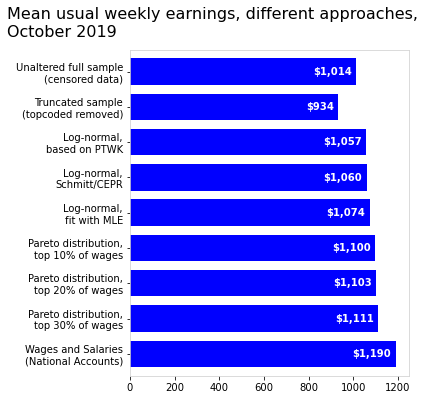

In [37]:
# Table 5 as a bar chart
t6p = t6
t6p.index = t6p.index.str.replace(', ', ',\n')
t6p.index = t6p.index.str.replace(' \(', '\n(', regex=True)
title = 'Mean usual weekly earnings, different approaches,\nOctober 2019'
t6p.iloc[::-1].plot(kind='barh', legend=False, 
        width=0.75, color='blue', figsize=(5, 6))
plt.text(-550, 9, title, fontsize=16)
for i, val in enumerate(t6p.iloc[::-1]['Estimated Mean']):
    plt.text(val - 20, i, f'${val:,.0f}', color='white', 
             ha='right', va='center', weight='bold')
    
plt.show()

In picking a method, one should consider reliability in and out of sample, consistency over time, theoretical basis, goodness of fit, and many other factors. One major benefit of the CEPR approach, as discussed by Schmitt, is that it involves minimal decisions about which data to use, beyond the assumption that wages are log-normally distributed. 

The tables and above provide some guidance for this decision based on the October 2019 data, but a subsequent section of this notebook shows the consistency over 2017-2019. First, one more potential issue with the usual weekly earnings data is discussed.

## Comparing to other data

This section discusses a potential issue based on documentation for the `EARNWEEK` variable from IPUMS. The IPUMS documentation says `EARNWEEK` uses the higher of usual weekly earnings or hourly pay times hours worked. 

Additionally, the data from 2017 to 2019 are graphed for various measures. Comparing across 36 observations shows how various adjustments affect and, hopefully, improve the results.

### Comparing to hours worked times hourly wage

The Minnesota Population Center and University of Minnesota's [IPUMS](https://ipums.org/mission-purpose) provides harmonized CPS extracts. The weekly pay variable is [described](https://cps.ipums.org/cps-action/variables/EARNWEEK#description_section) differently from my understanding of the usual weekly earnings recode variable `PRERNWA`. 

```
The figure given in EARNWEEK is the higher of the values derived from these two sources: 1) the respondent's answer to the question, "How much do you usually earn per week at this job before deductions?" or 2) for workers paid by the hour (and coded as "2" in PAIDHOUR), the reported number of hours the respondent usually worked at the job, multiplied by the hourly wage rate given in HOURWAGE.
```

In other words, it sounds like IPUMS replaces some weekly earnings values with the earnings the hourly wage rate times usual hours worked. But in the actual data from IPUMS, this is not the case. The variable `EARNWEEK` exactly matches `PRERNWA`. 

Perhaps the recode variable `PRERNWA` is already the higher of the two calculations, but I haven't confirmed this in other documentation. As I understand, this *should* be the case, as the weekly earnings data includes overtime, tips, and commissions, while the hourly rate does not. There *shouldn't* be cases where usual weekly pay is lower than the value calculated from usual hours and the hourly rate. 

But in October 2019, about 15 percent of hourly workers, or around 8 percent of workers, have higher earnings if calculated using hourly wages multiplied by usual hours worked. Beyond something like wage theft, I don't have a good explanation for these observations. Replacing the usual weekly earnings of some, disproporationately low-wage, workers with a higher value will increase the average wage. 

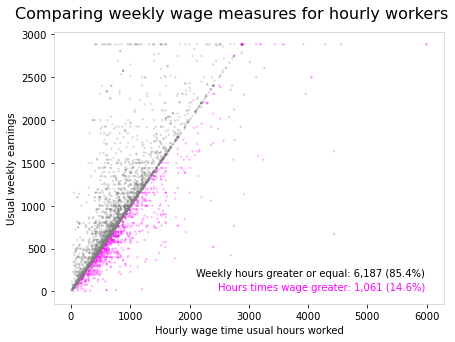

In [38]:
# Calculate weekly pay using hourly rate and usual hours
weekpay = (lambda x: np.where((x.PEHRUSL1 > 0) & (x.PRERNHLY > 0)
           & (x.PEERNHRY == 1), x.PRERNHLY * x.PEHRUSL1, np.nan))

wkpay_ratio = lambda x: (x.PRERNWA / x.WEEKPAY) - 1

wage_obs = wage_obs.assign(WEEKPAY = weekpay, 
                           WKPAY_RATIO = wkpay_ratio)

bins = [-10, 0, 50]
labels = ['Hours times wage greater', 
          'Weekly hours greater or equal']

wage_obs['Ratio_cat'] = pd.cut(wage_obs.WKPAY_RATIO, 
                               bins=bins, labels=labels, 
                               right=False)

plot_data = (wage_obs.dropna(subset=['WEEKPAY'])
                     .sort_values(by='WKPAY_RATIO'))
colors = {'Weekly hours greater or equal':'gray',
          'Hours times wage greater':'magenta'}
clist = plot_data['Ratio_cat'].apply(lambda x: colors[x]).values
xvals = plot_data.WEEKPAY.values
yvals = plot_data.PRERNWA.values

ct = wage_obs.groupby('Ratio_cat').PWORWGT.count()
ctsh = ct / ct.sum()

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(xvals, yvals, s=2, c=clist, alpha=0.2)
ax.set_ylabel('Usual weekly earnings')
ax.set_xlabel('Hourly wage time usual hours worked')
wwgeq = f'{ct[1]:,.0f} ({ctsh[1]*100:.1f}%)'
name = ('Weekly hours greater or equal')
ax.text(0.95, 0.1, f'{name}: {wwgeq}', 
        transform=ax.transAxes, ha='right')
htwg = f'{ct[0]:,.0f} ({ctsh[0]*100:.1f}%)'
ax.text(0.95, 0.05, f'Hours times wage greater: {htwg}', 
        transform=ax.transAxes, ha='right', color='magenta')
ax.text(-0.1, 1.05, 'Comparing weekly wage measures for hourly workers', 
        transform=ax.transAxes, size=16);

In October 2019, using the higher of the two measures raises the average wage by about \\$16 per week and raises the median wage by around \\$10 per week. If the cause for the gap between the two measures is indeed something like wage theft, it might not be good to artificially close the gap. If the gap is because of under-reporting of income, then it might make sense to use the higher of the two measures. 

As the scatterplot above shows, the cases affected (in magenta) are often earning less than \\$1,000 per week before deductions. Also, as shown further above, there is still a gap between aggregate-data-based estimates of mean earnings and the estimates that adjust for topcoding. Using the higher of the two measures would close the gap further. That said, I'm not sure why the IPUMS documentation and data are conflicting on this subject. If someone reads this and knows the answer, please send me an email.

In [39]:
# Create table summarizing change from using higher value
wkearn = lambda x: np.where(x.WKPAY_RATIO < 0, x.WEEKPAY, x.PRERNWA)
wage_obs = wage_obs.assign(WKEARN = wkearn)
tbl = pd.DataFrame()
for wage_var, name in [('WKEARN', 'Higher of two measures used'), ('PRERNWA', 'Unadjusted')]:
    cdf = cdf_generator(wage_obs, wage_var, 'PWORWGT')
    median = pct_interp(cdf, [0.5])[0]
    tbl.loc[name, 'Median'] = median
    vals = wage_obs[wage_var].values
    avg = np.average(vals, weights=wage_obs.PWORWGT.values)
    tbl.loc[name, 'Average'] = avg
    
tbl.style.format('${:,.2f}')

,Median,Average
Higher of two measures used,$810.62,"$1,030.46"
Unadjusted,$799.85,"$1,014.44"



### Comparing across 2017-2019

As a last step, this section combines 36 monthly CPS files to compare data from 2017 through 2019. The left plot compares the mean wage using different adjustments to the topcoded portion of the data with the national accounts equivalent and the unadjusted data. The right plot shows the median wage calculated using different methods.

When comparing currency values over time, researchers should always adjust for changes in the value of the currency. Doing so is straightforward and will be discussed in a later section, but for purposes of comparing these measures I'm going to use nominal values in the charts below (not adjusted for inflation). 

In [40]:
# Create new dataset with three years of wage observations
dates = pd.date_range('2017-01-01', '2019-12-01', freq='MS')
files = [f'{date.strftime("%b%y").lower()}pub.dat' for date in dates]

def cps_unpack_wage(file, unpacker, cols):
    '''
    Unpack each row and convert to pandas dataframe
    Only if weekly earnings > 0
    '''
    data = [[*map(int, unpacker(row))] for row 
            in open(file, 'rb').readlines()
            if int(row[526:534]) > 0]
    return pd.DataFrame(data, columns=cols)

d3y = pd.concat([(cps_unpack_wage(file, cps_unpacker(m), cols)
                  .pipe(cps_decimal_adjust, [earnvars, wgtvars])
                  .query('PRERNWA > 0')
                  .assign(BIN_WAGE = bin_wage, USLFT = uslft))
                 for file in files])

In [41]:
# Average weekly earnings using various measures
datecol = ['HRYEAR4', 'HRMONTH']
mean_grp = pd.DataFrame()

weighted_mean = lambda x: np.average(x.PRERNWA, weights=x.PWORWGT)
mean_grp['weighted'] = d3y.groupby(datecol).apply(weighted_mean)

mtcp = (d3y.groupby(datecol)
           .apply(lambda x: mtc_pareto(x, 0.8, 2884.61)['mtc'])
           .to_dict())

# Pareto imputed mean above topcode
d3y['PIMTC_WAGE'] = d3y.PRERNWA.copy()
for (year, month), value in mtcp.items():
    mask = (d3y.HRYEAR4 == year) & (d3y.HRMONTH == month) & (d3y.PTWK == 1)
    d3y.loc[mask, 'PIMTC_WAGE'] = value
pimtc_mean = lambda x: np.average(x.PIMTC_WAGE, weights=x.PWORWGT)
mean_grp['pimtc'] = d3y.groupby(datecol).apply(pimtc_mean)    

def mtc_cepr_spec(wage_obs):
    '''CEPR mean above topcode approach for specific columns'''
    wages = wage_obs.PRERNWA.values
    wgts = wage_obs.PWORWGT.values
    tc_share = (wage_obs.loc[wage_obs.PTWK == 1, 'PWORWGT'].sum() / 
                wage_obs.PWORWGT.sum())
    return mtc_cepr(wages, wgts, 2884.61, tc_share)

# Log-normal imputed mean above topcode
mtcl = (d3y.groupby(datecol)
           .apply(lambda x: mtc_cepr_spec(x))
           .to_dict())
d3y['LNIMTC_WAGE'] = d3y.PRERNWA.copy()
for (year, month), value in mtcl.items():
    mask = (d3y.HRYEAR4 == year) & (d3y.HRMONTH == month) & (d3y.PTWK == 1)
    d3y.loc[mask, 'LNIMTC_WAGE'] = value
lnimtc_mean = lambda x: np.average(x.LNIMTC_WAGE, weights=x.PWORWGT)
mean_grp['lnimtc'] = d3y.groupby(datecol).apply(lnimtc_mean)    
mean_grp.index = dates
mean_grp.index.name = ''

# BEA Aggregate data
ws = fred['WSperworker']
ws.index.name = ''

In [42]:
# Median weekly earnings for full-time workers, various measures
d3yf = d3y.query('USLFT == 1')
mdn_grp = pd.DataFrame()
mdn_grp['Simple'] = d3y.groupby(datecol).PRERNWA.median()

def libmw(df):
    '''
    Function to retrieve linear interpolated binned median wage
    '''
    cdfmi = cdf_generator(df, 'BIN_WAGE')
    return pct_interp_bin(cdfmi, 0.5)

# Linear interpolated binned median wage
binint = d3y.groupby(datecol).apply(lambda x: libmw(x))
mdn_grp['Binned Interpolated'] = binint
mdn_grp.index = dates

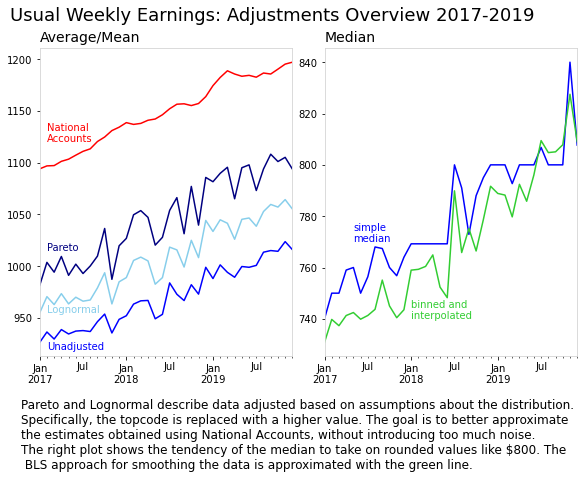

In [43]:
# Plot mean and median
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), 
                               constrained_layout=True)

mean_grp.plot(ax=ax1, color=['blue', 'navy', 'skyblue'], legend=None)
ws.loc['2017':'2019'].plot(ax=ax1, color='red', legend=None)
ax1.text('2017-02-01', 1120, 'National\nAccounts', color='red')
ax1.text('2017-02-01', 1015, 'Pareto', color='navy')
ax1.text('2017-02-01', 955, 'Lognormal', color='skyblue')
ax1.text('2017-02-01', 920, 'Unadjusted', color='blue')
ax1.text(0.0, 1.02, 'Average/Mean', size=14, transform=ax1.transAxes);

mdn_grp.plot(ax=ax2, color=['blue', 'limegreen'], legend=None)
ax2.text('2017-05-01', 770, 'simple\nmedian', color='blue')
ax2.text('2018-01-01', 740, 'binned and\ninterpolated', 
         color='limegreen')

ax2.text(0.0, 1.02, 'Median', size=14, transform=ax2.transAxes)

title = 'Usual Weekly Earnings: Adjustments Overview 2017-2019'
fig.text(0.01, 1.02, title, size=18)

footer = ('Pareto and Lognormal describe data adjusted based on '+
          'assumptions about the distribution.\nSpecifically, the '+
          'topcode is replaced with a higher value. The goal is to '+
          'better approximate\nthe estimates obtained using '+
          'National Accounts, without introducing too much noise.\n'+
          'The right plot shows the tendency of the median to take on '+
          'rounded values like \\$800. The\n BLS approach '+
          'for smoothing the data is approximated with '+
          'the green line.')
fig.text(0.03, -0.03, footer, size=12, va='top');

## Conclusion

Not all CPS households provide interviews and not all interviews provide wage information. Of the wage data that exists, much of it is either proxy responses or BLS-imputed values. Additionally, earnings above \\$150,000 per year are censored, and weekly earnings responses tend to cluster around rounded values (like $60,000 per year). 

As a result, researchers who want to study usual weekly earnings often use a subset of the data and/or use techniques to impute censored values. Techniques for estimating the mean earnings of the censored (topcoded) data suggest annual earnings for the top four percent of earners average between \\$200,000 and \\$275,000, in October 2019. Plugging that estimate in place of censored data can help with descriptive statistics and analysis of aggregate data. Researchers who want to study subgroups should be careful when replacing the topcoded values but can use these techniques to think about the missing data for the subgroup of interest.

The tendency of earnings data to bunch up around rounded values may reflect a combination of real world pay and peoples' tendency to round their actual pay in the interview. The clustering can affect estimates of wage growth, for example. As a result, researchers, including BLS, group wage observations into $50 ranges and interpolate the wage value that would correspond to an exact percentile. This technique works well.

Lastly, we can compare hourly workers' usual weekly earnings with their usual hours times rate of pay. I would like more documentation on this, but there are cases where individuals earnings calculated by usual hours times rate of pay are higher than the weekly total, which shouldn't be the case. It may be worth adjusting these cases.

Overall, making some minor adjustments to the weekly earnings data produces more accurate estimates of average earnings. Additionally, using a modified technique to calculate the median or other percentile earnings can help with the clustering issue.

#### Implications for bd CPS

The bd CPS will include the original usual weekly earnings variable and a second, adjusted, variable. The adjusted variable will replace topcoded values with the estimated mean above the topcode for eight groups by Census region and gender. The estimate of the mean above the topcode will assume a log-normal distribution of earnings and utilize the topcode flag `PTWK` to calculate the topcoded share of observations. The estimate will be calculated separately for each month of CPS data. For 2017-2019 this is represented by the light blue line in the previous graph.

## References

Bureau of Labor Statistics (2021). Usual Weekly Earnings Technical Note. [link](https://www.bls.gov/news.release/wkyeng.tn.htm)

Cai, J. & Baker, D. (2021). Masking Real Unemployment: The Overall and Racial Impact of Survey Non-Response on Measured Labor Market Outcomes. Working Paper. [link](https://www.ineteconomics.org/research/research-papers/masking-real-unemployment-the-overall-and-racial-impact-of-survey-non-response-on-measured-labor-market-outcomes)

Center for Economic and Policy Research (2020). CPS ORG Uniform Extracts, Version 2.5.

CEPRdata CPS ORG FAQ. [link](https://ceprdata.org/cps-uniform-data-extracts/cps-outgoing-rotation-group/cps-org-faq/)

CEPRdata CPS program for lognormal topcode [link](http://ceprdata.org/wp-content/cps/programs/org/cepr_org_topcode_lognormal.do)

Economic Policy Institute (2019). Methodology for measuring wages and benefits. [link](https://www.epi.org/data/methodology/)

Enders, C.K. (2010). *Applied Missing Data Analysis*. pp 46-48.

EPI Microdata Extracts. Methodology for wage variables. [link](https://microdata.epi.org/methodology/wagevariables/)

Flood, S., et. al. (2020) Integrated Public Use Microdata Series, Current Population Survey: Version 8.0. See [documentation](https://cps.ipums.org/cps-action/variables/EARNWEEK#description_section) for `EARNWEEK` variable. 

Greene, W.H. (2005). *Econometric Analysis*, 7th edition. See sections on Truncation and Censored Data.

Hirsch, B. & Schumacher, E.J. (2004). Match Bias in Wage Gap Estimates Due to Earnings Imputation. *Journal of Labor Economics*, vol. 22, issue 3, 689–722. [link](https://www.journals.uchicago.edu/doi/abs/10.1086/383112)

Rönkkö, M. (2020). Heckman sample selection model. YouTube video. [link](https://www.youtube.com/watch?v=dGLXUwGCu4A)

Schmitt, J. (2003). Creating a consistent hourly wage series from the Current Population Survey's Outgoing Rotation Group, 1979–2002. Working Paper. [link](https://ceprdata.org/wp-content/cps/CEPR_ORG_Wages.pdf)

Tobin, J. (1958). Estimation of Relationships for Limited Dependent Variables. *Econometrica*, vol. 26, issue 3, 24–36.

U.S. Census Bureau. (2019). *Current Population Survey Design and Methodology Technical Paper 77*. [link (PDF)](https://www2.census.gov/programs-surveys/cps/methodology/CPS-Tech-Paper-77.pdf)

## Future topics

* Hourly rate of pay (**part 2**)
    * Hourly vs nonhourly workers
    * Descriptive statistics
        * Topcoding, clumping, outliers
    * Overtime, tips, commissions
    * Usual hours vary
        * Imputed usual hours
    * Usual or actual?
* Comparing data over time (**part 3**)
    * Short periods
        * Seasonal adjustment
        * Clustering
        * Breaks in data/methodology
            * 1989
            * 1994
            * Later
        * Matching observations
            * Wage growth tracker
    * Longer periods
        * Real wages
            * CPI-U-RS
            * Regional CPI
        * Pseudo-panel from birth cohorts
* Family Income (**part 4**)
    * Categorical Data
    * Imputing data
        * Self-employed earnings
        * Unemployment income
        * Other income (?)